<h1>Farmer's Market Locator</h1>

<h2>The purpose of this program is to help locate a new farmer's market. We will use the restaurants and amenities surrounding existing farmer's markets in Colorado to form a fingerprint. We will use this fingerprint to assess new locations for suitability.</h2>

<p>
Farmer’s Market Locator Workflow

1.	Import libraries
2.	Load farmer’s market data
3.	Transform farmer’s market data
4.  Write function to add and subtract distance from geo coordinates
5.	Generate null datapoints for farmer’s markets
6.	Plot lat/lon datapoints on a map
7.	Pull Foursquare restaurants & amenities for each geo coordinate
8.	Merge farmer’s market & Foursquare data
9.	Split training & test data
10.	Test k values for KNeighbors classifier
11.	Train KNeighbors classifier
12.	Create a grid of lat/lon coordinates over Denver
13. Plot test coordinates on map
14.	Pull Foursquare data for each lat/lon in the grid
15.	Run each gridpoint against the KNeighbors model
16.	Plot a map of Denver with predicted farmer's market locations from gridpoints
17. Closing thoughts


</p>

<h3>1. Import libraries</h3>

In [1]:
import pandas as pd

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

pd.options.mode.chained_assignment = None  # default='warn'

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment once installed
import folium # map rendering library
from folium import plugins

import math

import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

<h3>2. Load farmer's market data</h3>

In [4]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_e8bcd0bea0ad43e59ef85aee72645133 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='0H-hMIHzZukdyk_ejsJoe_lBf4QC4drXDcHUTbcd9msQ',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e8bcd0bea0ad43e59ef85aee72645133.get_object(Bucket='courseracapstone-donotdelete-pr-fye9c0xmyql7dv',Key='farmers_markets_from_usda.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,FMID,MarketName,Website,Facebook,Twitter,Youtube,OtherMedia,street,city,County,...,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested,updateTime
0,1018261,Caledonia Farmers Market Association - Danville,https://sites.google.com/site/caledoniafarmers...,https://www.facebook.com/Danville.VT.Farmers.M...,NaN,NaN,NaN,NaN,Danville,Caledonia,...,Y,Y,Y,N,N,Y,Y,N,N,6/20/2017 22:43
1,1018318,Stearns Homestead Farmers' Market,http://www.StearnsHomestead.com,StearnsHomesteadFarmersMarket,NaN,NaN,NaN,6975 Ridge Road,Parma,Cuyahoga,...,N,N,Y,N,N,N,N,N,N,6/21/2017 17:15
2,1009364,106 S. Main Street Farmers Market,http://thetownofsixmile.wordpress.com/,NaN,NaN,NaN,NaN,106 S. Main Street,Six Mile,Pickens,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013
3,1010691,10th Steet Community Farmers Market,NaN,NaN,NaN,NaN,http://agrimissouri.com/mo-grown/grodetail.php...,10th Street and Poplar,Lamar,Barton,...,N,N,Y,N,N,N,N,N,N,10/28/2014 9:49
4,1002454,112st Madison Avenue,NaN,NaN,NaN,NaN,NaN,112th Madison Avenue,New York,New York,...,N,N,N,N,N,N,N,N,N,3/1/2012 10:38


<h3>3. Transform farmer's market data</h3>

In [5]:
df_data_1.columns.values

array(['FMID', 'MarketName', 'Website', 'Facebook', 'Twitter', 'Youtube',
       'OtherMedia', 'street', 'city', 'County', 'State', 'zip',
       'Season1Date', 'Season1Time', 'Season2Date', 'Season2Time',
       'Season3Date', 'Season3Time', 'Season4Date', 'Season4Time', 'x',
       'y', 'Location', 'Credit', 'WIC', 'WICcash', 'SFMNP', 'SNAP',
       'Organic', 'Bakedgoods', 'Cheese', 'Crafts', 'Flowers', 'Eggs',
       'Seafood', 'Herbs', 'Vegetables', 'Honey', 'Jams', 'Maple', 'Meat',
       'Nursery', 'Nuts', 'Plants', 'Poultry', 'Prepared', 'Soap',
       'Trees', 'Wine', 'Coffee', 'Beans', 'Fruits', 'Grains', 'Juices',
       'Mushrooms', 'PetFood', 'Tofu', 'WildHarvested', 'updateTime'],
      dtype=object)

In [6]:
df_data_1.shape

(8804, 59)

In [7]:
coloradoFilter = df_data_1[df_data_1['State'] == 'Colorado']
coloradoFilter.head()

,FMID,MarketName,Website,Facebook,Twitter,Youtube,OtherMedia,street,city,County,...,Coffee,Beans,Fruits,Grains,Juices,Mushrooms,PetFood,Tofu,WildHarvested,updateTime
37,1006234,4th Street Farmers Market,http://www.4thstreetfarmersmarket.com,NaN,NaN,NaN,NaN,315 East 4th St.,Loveland,Larimer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
114,1004070,Alamosa Farmers Market,http://www.alamosafarmersmarket.org,https://www.facebook.com/pages/Alamosa-Farmers...,NaN,NaN,NaN,Corner of 6th Street and State Avenue's Munici...,Alamosa,Alamosa,...,N,Y,Y,N,N,N,N,N,N,3/19/2015 16:25
179,1001367,American National Bank Downtown Farmers Market...,NaN,NaN,NaN,NaN,NaN,5th and Rood Avenue,Grand Junction,Mesa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011
289,1005081,Arvada Farmers Market,http://www.arvadafarmersmarket.com,https://www.facebook.com/arvadafarmersmarket,NaN,NaN,NaN,57th St. & Olde Wadsworth St.,Arvada,Jefferson,...,N,N,Y,N,N,N,N,N,N,6/27/2013 12:40
290,1009285,Arvada Five Parks Farmers Market,http://www.arvadafiveparksfarmersmarket.blogsp...,https://www.facebook.com/pages/Arvada-Five-Par...,NaN,NaN,NaN,13810 W. 85th Dr.,Arvada,Jefferson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013


In [8]:
farmersMarkets = coloradoFilter[['FMID','MarketName','x','y']]
farmersMarkets.head()

,FMID,MarketName,x,y
37,1006234,4th Street Farmers Market,-105.07300,40.395401
114,1004070,Alamosa Farmers Market,-105.86523,37.468361
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199
289,1005081,Arvada Farmers Market,-105.08145,39.800137
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801


In [9]:
farmersMarkets.columns = ['id', 'name', 'lon', 'lat']
farmersMarkets.head()

,id,name,lon,lat
37,1006234,4th Street Farmers Market,-105.07300,40.395401
114,1004070,Alamosa Farmers Market,-105.86523,37.468361
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199
289,1005081,Arvada Farmers Market,-105.08145,39.800137
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801


In [10]:
farmersMarkets['farmersMarket'] = 1.0
farmersMarkets.head(10)

,id,name,lon,lat,farmersMarket
37,1006234,4th Street Farmers Market,-105.07300,40.395401,1.0
114,1004070,Alamosa Farmers Market,-105.86523,37.468361,1.0
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199,1.0
289,1005081,Arvada Farmers Market,-105.08145,39.800137,1.0
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801,1.0
313,1004692,Aspen Grove Farmers' Market,-105.02522,39.585506,1.0
314,1005837,Aspen Saturday Market,-106.81700,39.189400,1.0
440,1003335,Basalt Sunday Market,-107.03600,39.368801,1.0
461,1016880,Bayfield Downtown Farmers Market,-107.60290,37.225578,1.0
471,1009473,Be Local Winter Farmer's Market,-105.07800,40.587799,1.0


In [11]:
farmersMarkets.sort_values("name", inplace = True)
farmersMarkets.head()

,id,name,lon,lat,farmersMarket
37,1006234,4th Street Farmers Market,-105.07300,40.395401,1.0
114,1004070,Alamosa Farmers Market,-105.86523,37.468361,1.0
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199,1.0
289,1005081,Arvada Farmers Market,-105.08145,39.800137,1.0
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801,1.0


In [12]:
farmersMarkets.drop_duplicates(subset ="name", keep = False, inplace = True)
farmersMarkets.head()

,id,name,lon,lat,farmersMarket
37,1006234,4th Street Farmers Market,-105.07300,40.395401,1.0
114,1004070,Alamosa Farmers Market,-105.86523,37.468361,1.0
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199,1.0
289,1005081,Arvada Farmers Market,-105.08145,39.800137,1.0
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801,1.0


In [13]:
farmersMarkets.shape

(157, 5)

In [14]:
farmersMarkets.describe()

,id,lon,lat,farmersMarket
count,1.570000e+02,157.000000,157.000000,157.0
mean,1.007478e+06,-105.646049,39.287196,1.0
std,5.335725e+03,1.201596,0.918072,0.0
min,1.000015e+06,-108.903590,37.165695,1.0
25%,1.003506e+06,-106.145810,38.824673,1.0
50%,1.006069e+06,-105.081350,39.591408,1.0
75%,1.010302e+06,-104.899740,39.925007,1.0
max,1.019739e+06,-103.236300,40.704819,1.0


<h3>4. Write function to add and subtract distance from geo coordinates</h3>
<p>This function probably won't be used, but I've kept it for reference. Instead I will use the math to calculate the latitude offsets which will then be used to generate the negative datapoints. 

In [15]:
def addDistance(distance, lat, lon, angle):
        distanceNorth = math.sin(math.radians(angle)) * distance
        distanceEast = math.cos(math.radians(angle)) * distance
        
        earthRadius = 3959
        
        newLat = lat + (distanceNorth / earthRadius) * 180 / math.pi
        newLon = lon + (distanceEast / (earthRadius * math.cos(math.radians(newLat * 180 / math.pi )))) * 180 / math.pi
        
        return (newLat, newLon)

In [16]:
print(addDistance(3, 40.395401,-105.07300, 0))
print(addDistance(3, 40.395401,-105.07300, 90))
print(addDistance(3, 40.395401,-105.07300, 180))
print(addDistance(3, 40.395401,-105.07300, 270))

(40.395401, -105.12110838835565)
(40.4388178574234, -105.073)
(40.395401, -105.02489161164434)
(40.3519841425766, -105.073)


In [17]:
print(addDistance(1, 40.395401,-105.07300, 270))
print(addDistance(3, 40.395401,-105.07300, 270))
print(addDistance(6, 40.395401,-105.07300, 270))
print(addDistance(20, 40.395401,-105.07300, 270))
print(addDistance(60, 40.395401,-105.07300, 270))

(40.3809287141922, -105.073)
(40.3519841425766, -105.073)
(40.308567285153195, -105.073)
(40.10595528384399, -105.073)
(39.52706385153197, -105.073)


In [18]:
print(addDistance(7, 39.7255006,-105.0235998, 270))

(39.624194599345394, -105.0235998)


<h3>5. Generate null datapoints for farmer’s markets</h3>

In [19]:
threeMilesAway = farmersMarkets.copy()
sixMilesAway = farmersMarkets.copy()
twentyMilesAway = farmersMarkets.copy()
sixtyMilesAway = farmersMarkets.copy()

threeMilesAway.head()

,id,name,lon,lat,farmersMarket
37,1006234,4th Street Farmers Market,-105.07300,40.395401,1.0
114,1004070,Alamosa Farmers Market,-105.86523,37.468361,1.0
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199,1.0
289,1005081,Arvada Farmers Market,-105.08145,39.800137,1.0
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801,1.0


In [20]:
threeMiles = (0.014472286 * 3)
sixMiles = (0.014472286 * 6)
twentyMiles = (0.014472286 * 20)
sixtyMiles = (0.014472286 * 60)

print(sixtyMiles)


0.8683371599999999


In [21]:
threeMilesAway['lat'] = threeMilesAway['lat'] - threeMiles
threeMilesAway['id'] = threeMilesAway['id'] * 2
farmersMarketNegative = threeMilesAway

In [22]:
sixMilesAway['lat'] = sixMilesAway['lat'] - sixMiles
sixMilesAway['id'] = sixMilesAway['id'] * 3
farmersMarketNegative = farmersMarketNegative.append(sixMilesAway, ignore_index = True)

In [23]:
twentyMilesAway['lat'] = twentyMilesAway['lat'] - twentyMiles
twentyMilesAway['id'] = twentyMilesAway['id'] * 4
farmersMarketNegative = farmersMarketNegative.append(twentyMilesAway, ignore_index = True)

In [24]:
sixtyMilesAway['lat'] = sixtyMilesAway['lat'] - sixtyMiles
sixtyMilesAway['id'] = sixtyMilesAway['id'] * 5
farmersMarketNegative = farmersMarketNegative.append(sixtyMilesAway, ignore_index = True)

In [25]:
farmersMarketNegative.shape

(628, 5)

In [26]:
farmersMarketNegative['farmersMarket'] = 0.0
farmersMarketNegative.head()

,id,name,lon,lat,farmersMarket
0,2012468,4th Street Farmers Market,-105.07300,40.351984,0.0
1,2008140,Alamosa Farmers Market,-105.86523,37.424944,0.0
2,2002734,American National Bank Downtown Farmers Market...,-108.56400,39.024782,0.0
3,2010162,Arvada Farmers Market,-105.08145,39.756720,0.0
4,2018570,Arvada Five Parks Farmers Market,-105.15500,39.805384,0.0


In [27]:
farmersMarkets.head()

,id,name,lon,lat,farmersMarket
37,1006234,4th Street Farmers Market,-105.07300,40.395401,1.0
114,1004070,Alamosa Farmers Market,-105.86523,37.468361,1.0
179,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199,1.0
289,1005081,Arvada Farmers Market,-105.08145,39.800137,1.0
290,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801,1.0


In [28]:
farmersMarketNegative.head()

,id,name,lon,lat,farmersMarket
0,2012468,4th Street Farmers Market,-105.07300,40.351984,0.0
1,2008140,Alamosa Farmers Market,-105.86523,37.424944,0.0
2,2002734,American National Bank Downtown Farmers Market...,-108.56400,39.024782,0.0
3,2010162,Arvada Farmers Market,-105.08145,39.756720,0.0
4,2018570,Arvada Five Parks Farmers Market,-105.15500,39.805384,0.0


In [29]:
farmersMarketCombined = farmersMarkets.append(farmersMarketNegative, ignore_index = True)
print(farmersMarketCombined.shape)

farmersMarketCombined.head()

(785, 5)


,id,name,lon,lat,farmersMarket
0,1006234,4th Street Farmers Market,-105.07300,40.395401,1.0
1,1004070,Alamosa Farmers Market,-105.86523,37.468361,1.0
2,1001367,American National Bank Downtown Farmers Market...,-108.56400,39.068199,1.0
3,1005081,Arvada Farmers Market,-105.08145,39.800137,1.0
4,1009285,Arvada Five Parks Farmers Market,-105.15500,39.848801,1.0


In [30]:
del farmersMarketCombined['name']
farmersMarketCombined.head()

,id,lon,lat,farmersMarket
0,1006234,-105.07300,40.395401,1.0
1,1004070,-105.86523,37.468361,1.0
2,1001367,-108.56400,39.068199,1.0
3,1005081,-105.08145,39.800137,1.0
4,1009285,-105.15500,39.848801,1.0


In [31]:
farmersMarketCombined.describe()

,id,lon,lat,farmersMarket
count,7.850000e+02,785.000000,785.000000,785.000000
mean,3.022433e+06,-105.646049,39.029589,0.200000
std,1.425806e+06,1.198526,0.970448,0.400255
min,1.000015e+06,-108.903590,36.297358,0.000000
25%,2.007012e+06,-106.145810,38.436007,0.000000
50%,3.018207e+06,-105.081350,39.255117,0.000000
75%,4.041208e+06,-104.899740,39.711102,0.000000
max,5.098695e+06,-103.236300,40.704819,1.000000


In [32]:
farmersMarketCombined = farmersMarketCombined.rename(columns={"id":"uniqueId"})
farmersMarketCombined.head()

,uniqueId,lon,lat,farmersMarket
0,1006234,-105.07300,40.395401,1.0
1,1004070,-105.86523,37.468361,1.0
2,1001367,-108.56400,39.068199,1.0
3,1005081,-105.08145,39.800137,1.0
4,1009285,-105.15500,39.848801,1.0


In [33]:
farmersMarketCombined.dtypes

uniqueId           int64
lon              float64
lat              float64
farmersMarket    float64
dtype: object

In [34]:
farmersMarketCombined['lat'].value_counts()

38.737839    2
38.535227    2
37.956336    2
38.781256    2
38.824673    2
38.127242    1
37.677283    1
39.781166    1
40.135820    1
37.182161    1
40.428368    1
39.099300    1
39.624268    1
40.232862    1
39.274361    1
38.185265    1
40.305328    1
39.868000    1
36.476763    1
38.742518    1
36.983618    1
39.675611    1
38.995579    1
40.425266    1
40.192091    1
39.097000    1
39.660742    1
37.562899    1
39.998066    1
39.230330    1
            ..
36.915003    1
39.189400    1
37.974337    1
40.142792    1
38.372799    1
37.893492    1
38.889704    1
39.574102    1
39.795454    1
38.751196    1
39.494650    1
39.467865    1
38.787954    1
36.984008    1
39.547081    1
37.721418    1
36.297358    1
38.990561    1
39.567764    1
39.633162    1
37.862352    1
39.503389    1
39.421656    1
39.653366    1
39.971827    1
38.764666    1
39.330553    1
39.115454    1
38.682701    1
37.055654    1
Name: lat, Length: 780, dtype: int64

<h3>6. Plot lat/lon datapoints on a map </h3>

In [35]:
mapColorado = folium.Map(location=[39.742043, -104.991531], zoom_start=7.5)

# instantiate a feature group for the rows in the dataframe
markets = folium.map.FeatureGroup()
negatives = folium.map.FeatureGroup()

marketsPlotted=0
negativesPlotted=0

# loop through rows and add each to the markets feature group
for lat, lon, in zip(farmersMarkets.lat, farmersMarkets.lon):
    marketsPlotted = marketsPlotted + 1
    markets.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
# loop through rows and add each to the negatives feature group
for lat, lon, in zip(farmersMarketNegative.lat, farmersMarketNegative.lon):
    negativesPlotted = negativesPlotted + 1
    negatives.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


# add incidents to map
mapColorado.add_child(markets)
mapColorado.add_child(negatives)
mapColorado

In [36]:
print(marketsPlotted)
print(negativesPlotted)

157
628


<h3> Pull Foursquare restaurants & amenities for each geo coordinate </h3>

In [197]:
CLIENT_ID = '# your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = '# your Foursquare Secret' # your Foursquare Secret
VERSION = '20200625' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: # your Foursquare ID
CLIENT_SECRET:# your Foursquare Secret


In [38]:
LIMIT = 100

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
farmersMarketVenues = getNearbyVenues(names=farmersMarketCombined['uniqueId'], latitudes=farmersMarketCombined['lat'], longitudes=farmersMarketCombined['lon'])

1006234
1004070
1001367
1005081
1009285
1004692
1005837
1003335
1016880
1009473
1009929
1011149
1003939
1003353
1012335
1006305
1004823
1006306
1017989
1007369
1006844
1006846
1006847
1018360
1003292
1003143
1002817
1011055
1009284
1011057
1010079
1004255
1010773
1008959
1009282
1000756
1005035
1017973
1004069
1001118
1000417
1019439
1011155
1018361
1018953
1003880
1005920
1001298
1006377
1004525
1005654
1000015
1001957
1006251
1001888
1008941
1007865
1003146
1003116
1011136
1002901
1011779
1010115
1005569
1006245
1000714
1002373
1001645
1006699
1003531
1005099
1006866
1002360
1003819
1003820
1005025
1001675
1002312
1005337
1004688
1004433
1005126
1009238
1009283
1004526
1011107
1011058
1000133
1006742
1001861
1003334
1007747
1005911
1011137
1007734
1001672
1005570
1004710
1004744
1012348
1007652
1005150
1017913
1000418
1012094
1002856
1012779
1019507
1006304
1004527
1011232
1004982
1001377
1011253
1000419
1000315
1008981
1001862
1007748
1006860
1019478
1003506
1008079
1002707
1009519


In [42]:
print(farmersMarketVenues.shape)
farmersMarketVenues.head()

(4788, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1006234,40.395401,-105.073,The Coffee Tree,40.395321,-105.074217,Coffee Shop
1,1006234,40.395401,-105.073,Verboten Brewing,40.396638,-105.075114,Brewery
2,1006234,40.395401,-105.073,Door 222,40.395280,-105.073922,New American Restaurant
3,1006234,40.395401,-105.073,Henry's Pub,40.395312,-105.073650,Pub
4,1006234,40.395401,-105.073,Laureate Publick House,40.396900,-105.073027,Pub


In [43]:
farmersMarketVenues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
1000015,28,28,28,28,28,28
1000133,92,92,92,92,92,92
1000315,22,22,22,22,22,22
1000417,16,16,16,16,16,16
1000418,7,7,7,7,7,7
1000419,29,29,29,29,29,29
1000714,4,4,4,4,4,4
1000756,7,7,7,7,7,7
1001298,36,36,36,36,36,36


In [44]:
print('There are {} uniques categories.'.format(len(farmersMarketVenues['Venue Category'].unique())))

There are 336 uniques categories.


In [45]:
# one hot encoding
farmers_onehot = pd.get_dummies(farmersMarketVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
farmers_onehot['Neighborhood'] = farmersMarketVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [farmers_onehot.columns[-1]] + list(farmers_onehot.columns[:-1])
farmers_onehot = farmers_onehot[fixed_columns]

farmers_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,1006234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1006234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1006234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1006234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1006234,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
farmers_onehot.shape

(4788, 337)

In [47]:
farmers_grouped = farmers_onehot.groupby('Neighborhood').mean().reset_index()
farmers_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,1000015,0.000000,0.000000,0.0,0.0,0.0,0.107143,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,1000133,0.010870,0.000000,0.0,0.0,0.0,0.054348,0.0,0.0,0.01087,...,0.000000,0.0,0.00,0.01087,0.010870,0.000000,0.0,0.0,0.000000,0.000000
2,1000315,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,1000417,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,1000418,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
5,1000419,0.000000,0.000000,0.0,0.0,0.0,0.068966,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.034483,0.000000,0.0,0.0,0.000000,0.000000
6,1000714,0.000000,0.000000,0.0,0.0,0.0,0.250000,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
7,1000756,0.000000,0.000000,0.0,0.0,0.0,0.142857,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
8,1001298,0.000000,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
9,1001367,0.026316,0.000000,0.0,0.0,0.0,0.078947,0.0,0.0,0.00000,...,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


<h3> 8. Merge farmer’s market & Foursquare data </h3>

In [48]:
farmers_grouped.shape
farmers_grouped.rename(columns={"Neighborhood":"uniqueId"}, inplace = True)
farmers_grouped.head()

,uniqueId,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,1000015,0.00000,0.0,0.0,0.0,0.0,0.107143,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
1,1000133,0.01087,0.0,0.0,0.0,0.0,0.054348,0.0,0.0,0.01087,...,0.0,0.0,0.0,0.01087,0.01087,0.0,0.0,0.0,0.0,0.0
2,1000315,0.00000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
3,1000417,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0
4,1000418,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0


In [49]:
farmersMarketCombined.head()

,uniqueId,lon,lat,farmersMarket
0,1006234,-105.07300,40.395401,1.0
1,1004070,-105.86523,37.468361,1.0
2,1001367,-108.56400,39.068199,1.0
3,1005081,-105.08145,39.800137,1.0
4,1009285,-105.15500,39.848801,1.0


In [50]:
farmersMarketShort = farmersMarketCombined.copy()
del farmersMarketShort['lon']
del farmersMarketShort['lat']
farmersMarketShort.head()

,uniqueId,farmersMarket
0,1006234,1.0
1,1004070,1.0
2,1001367,1.0
3,1005081,1.0
4,1009285,1.0


In [51]:
farmersFinal = pd.merge(farmers_grouped, farmersMarketShort, on ="uniqueId", how ='right') 

In [52]:
farmersFinal.head()

,uniqueId,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,farmersMarket
0,1000015,0.00000,0.0,0.0,0.0,0.0,0.107143,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0
1,1000133,0.01087,0.0,0.0,0.0,0.0,0.054348,0.0,0.0,0.01087,...,0.0,0.0,0.01087,0.01087,0.0,0.0,0.0,0.0,0.0,1.0
2,1000315,0.00000,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0
3,1000417,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0
4,1000418,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,1.0


In [53]:
farmersFinal.shape

(785, 338)

In [54]:
farmersFinal = farmersFinal.fillna(0.0)

<h3>9. Split training & test data</h3>

In [55]:
train, test = train_test_split(farmersFinal, test_size=0.2, random_state=4)
print(train.shape)
print(test.shape)

(628, 338)
(157, 338)


In [56]:
train.loc[:,'ATM':'Yoga Studio']

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,...,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
325,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
545,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
270,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
650,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
643,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
737,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
625,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
306,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
273,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000
179,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.2,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000


In [57]:
train['farmersMarket']

325    0.0
545    0.0
270    0.0
650    0.0
643    0.0
737    0.0
625    0.0
306    0.0
273    0.0
179    0.0
405    0.0
300    0.0
769    0.0
770    0.0
379    0.0
413    0.0
90     1.0
336    0.0
286    0.0
511    0.0
389    0.0
390    0.0
8      1.0
697    0.0
275    0.0
749    0.0
675    0.0
576    0.0
328    1.0
176    0.0
      ... 
783    0.0
706    0.0
56     1.0
486    0.0
509    0.0
422    0.0
713    0.0
149    1.0
533    0.0
183    0.0
0      1.0
387    0.0
564    0.0
126    1.0
294    0.0
44     1.0
676    0.0
313    0.0
606    0.0
109    1.0
764    0.0
58     1.0
393    0.0
456    0.0
599    0.0
360    0.0
709    0.0
439    0.0
174    0.0
122    1.0
Name: farmersMarket, Length: 628, dtype: float64

<h3>10.	Test k values for KNeighbors classifier</h3>


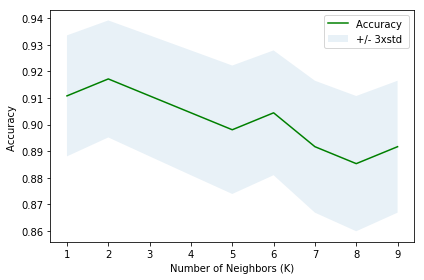

In [58]:
Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train.loc[:,'ATM':'Yoga Studio'],train['farmersMarket'])
    yhat=neigh.predict(test.loc[:,'ATM':'Yoga Studio'])
    mean_acc[n-1] = metrics.accuracy_score(test['farmersMarket'], yhat)

    
    std_acc[n-1]=np.std(yhat==test['farmersMarket'])/np.sqrt(yhat.shape[0])

mean_acc

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

<h3>11.	Train KNeighbors classifier</h3>

In [59]:
k = 2
neigh = KNeighborsClassifier(n_neighbors = k).fit(train.loc[:,'ATM':'Yoga Studio'],train['farmersMarket'])
yhat = neigh.predict(test.loc[:,'ATM':'Yoga Studio'])

print("Train set Accuracy: ", metrics.accuracy_score(train['farmersMarket'], neigh.predict(train.loc[:,'ATM':'Yoga Studio'])))
print("Test set Accuracy: ", metrics.accuracy_score(test['farmersMarket'], yhat))

Train set Accuracy:  0.9506369426751592
Test set Accuracy:  0.9171974522292994


<h3>12.	Create a grid of lat/lon coordinates over Denver</h3>

In [128]:
originLat = 39.7537857
originLon = -105.0627884
endLat = 39.6826163
endLon = -104.9982307

39.624194599345394

39.624194599345394

In [185]:
y = np.linspace(originLat, endLat, num = 20)
x = np.linspace(originLon, endLon, num = 20)
xx,yy=np.meshgrid(y,x)
coords=np.array((xx.ravel(), yy.ravel())).T
coords

array([[  39.7537857 , -105.0627884 ],
       [  39.75003994, -105.0627884 ],
       [  39.74629418, -105.0627884 ],
       [  39.74254843, -105.0627884 ],
       [  39.73880267, -105.0627884 ],
       [  39.73505691, -105.0627884 ],
       [  39.73131115, -105.0627884 ],
       [  39.72756539, -105.0627884 ],
       [  39.72381964, -105.0627884 ],
       [  39.72007388, -105.0627884 ],
       [  39.71632812, -105.0627884 ],
       [  39.71258236, -105.0627884 ],
       [  39.70883661, -105.0627884 ],
       [  39.70509085, -105.0627884 ],
       [  39.70134509, -105.0627884 ],
       [  39.69759933, -105.0627884 ],
       [  39.69385357, -105.0627884 ],
       [  39.69010782, -105.0627884 ],
       [  39.68636206, -105.0627884 ],
       [  39.6826163 , -105.0627884 ],
       [  39.7537857 , -105.05939063],
       [  39.75003994, -105.05939063],
       [  39.74629418, -105.05939063],
       [  39.74254843, -105.05939063],
       [  39.73880267, -105.05939063],
       [  39.73505691, -1

In [186]:
testPoints = pd.DataFrame(coords)
testPoints.head()

,0,1
0,39.753786,-105.062788
1,39.750040,-105.062788
2,39.746294,-105.062788
3,39.742548,-105.062788
4,39.738803,-105.062788


In [187]:
testPoints.columns = ['lat', 'lon']
testPoints.head()

,lat,lon
0,39.753786,-105.062788
1,39.750040,-105.062788
2,39.746294,-105.062788
3,39.742548,-105.062788
4,39.738803,-105.062788


<h3>13. Plot test coordinates on map</h3>

In [140]:
mapDenver = folium.Map(location=[39.7255006, -105.0235998], zoom_start=13)

# instantiate a feature group for the rows in the dataframe
testPointsPlot = folium.map.FeatureGroup()

testPointsPlotted=0

# loop through rows and add each to the markets feature group
for lat, lon, in zip(testPoints.lat, testPoints.lon):
    testPointsPlotted = testPointsPlotted + 1
    testPointsPlot.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
mapDenver.add_child(testPointsPlot)
mapDenver

<h3>14. Pull Foursquare data for each lat/lon in the grid</h3>

In [141]:
testPoints.insert(0, 'New_ID', range(880, 880 + len(testPoints)))

In [142]:
testPoints.head()

,New_ID,lat,lon
0,880,39.753786,-105.062788
1,881,39.750040,-105.062788
2,882,39.746294,-105.062788
3,883,39.742548,-105.062788
4,884,39.738803,-105.062788


In [143]:
testPointsVenues = getNearbyVenues(names=testPoints['New_ID'], latitudes=testPoints['lat'], longitudes=testPoints['lon'])

880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103


In [166]:
# one hot encoding
testPoints_onehot = pd.get_dummies(testPointsVenues[['Venue Category']], prefix="", prefix_sep="")
testPoints_onehot.head()

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Alternative Healer,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
# add neighborhood column back to dataframe
testPoints_onehot['New_ID'] = testPoints['New_ID'] 

# move neighborhood column to the first column
fixed_columns = [testPoints_onehot.columns[-1]] + list(testPoints_onehot.columns[:-1])
testPoints_onehot = testPoints_onehot[fixed_columns]

testPoints_onehot.head()

,New_ID,ATM,Accessories Store,Adult Boutique,Advertising Agency,Alternative Healer,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,880.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,881.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,882.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,883.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,884.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
testPoints_grouped = testPoints_onehot.groupby('New_ID').mean().reset_index()
testPoints_grouped

,New_ID,ATM,Accessories Store,Adult Boutique,Advertising Agency,Alternative Healer,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,...,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,880.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,881.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,882.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,883.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,884.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,885.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,886.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,887.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,888.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,889.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>15. Run each gridpoint against the KNeighbors model </h3>

In [169]:
print(train.loc[:,'ATM':'Yoga Studio'].shape)
print(testPoints_grouped.loc[:,'ATM':'Yoga Studio'].shape)

(628, 336)
(400, 249)


In [170]:
trainingColumns = train.loc[:,'ATM':'Yoga Studio']
testPointsColumns = testPoints_grouped.loc[:,'ATM':'Yoga Studio']
col_list = list(set().union(trainingColumns.columns, testPointsColumns.columns))
col_list.sort()
col_list

['ATM',
 'Accessories Store',
 'Adult Boutique',
 'Advertising Agency',
 'Airport',
 'Alternative Healer',
 'American Restaurant',
 'Animal Shelter',
 'Antique Shop',
 'Aquarium',
 'Arcade',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Assisted Living',
 'Astrologer',
 'Athletics & Sports',
 'Auto Garage',
 'Auto Workshop',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Garden',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Board Shop',
 'Bookstore',
 'Boutique',
 'Bowling Alley',
 'Boxing Gym',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Buffet',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'Business Service

In [171]:
testPoints_grouped = testPoints_grouped.reindex(columns=col_list, fill_value=0)

In [172]:
print(train.loc[:,'ATM':'Yoga Studio'].shape)
print(testPoints_grouped.loc[:,'ATM':'Yoga Studio'].shape)

(628, 336)
(400, 368)


In [173]:
trainColumns = train.loc[:,'ATM':'Yoga Studio'].columns
testPointsColumns = testPoints_grouped.loc[:,'ATM':'Yoga Studio'].columns

In [174]:
columnDiff = list(set(testPoints_grouped.columns.values) - set(train.columns.values))
columnDiff

['Strip Club',
 'Fish Market',
 'Paintball Field',
 'Argentinian Restaurant',
 'General Travel',
 'Cuban Restaurant',
 'Butcher',
 'Dim Sum Restaurant',
 'Indie Theater',
 'Alternative Healer',
 'Tennis Court',
 'Health Food Store',
 'Residential Building (Apartment / Condo)',
 'Baseball Stadium',
 'Event Service',
 'Road',
 'Ski Shop',
 'Caribbean Restaurant',
 'Pawn Shop',
 'Aquarium',
 'Neighborhood',
 'Financial or Legal Service',
 'Cycle Studio',
 'Trade School',
 'Climbing Gym',
 'Piano Bar',
 'Public Art',
 'Cantonese Restaurant',
 'Shop & Service',
 'Forest',
 'Lighting Store',
 'Churrascaria']

In [175]:
testPoints_grouped = testPoints_grouped.drop(columnDiff, axis = 1)
testPoints_grouped.shape

(400, 336)

In [176]:
testPointResults = neigh.predict(testPoints_grouped.loc[:,'ATM':'Yoga Studio'])

In [177]:
testPointResults

array([1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0.

In [178]:
flattenedResults = pd.DataFrame(data=testPointResults.flatten())

In [179]:
flattenedResults.rename(columns={0:"farmersMarket"}, inplace = True)
flattenedResults.head()

,farmersMarket
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0


<h3>16. Plot a map of Denver with predicted farmer's market locations from gridpoints</h3>

In [189]:
testPoints = testPoints.join(flattenedResults, how='outer')
testPoints.head()

,lat,lon,farmersMarket
0,39.753786,-105.062788,1.0
1,39.750040,-105.062788,0.0
2,39.746294,-105.062788,0.0
3,39.742548,-105.062788,1.0
4,39.738803,-105.062788,1.0


In [190]:
positives = testPoints[(testPoints.farmersMarket == 1.0)]
positives.head(10)

,lat,lon,farmersMarket
0,39.753786,-105.062788,1.0
3,39.742548,-105.062788,1.0
4,39.738803,-105.062788,1.0
10,39.716328,-105.062788,1.0
18,39.686362,-105.062788,1.0
20,39.753786,-105.059391,1.0
21,39.750040,-105.059391,1.0
44,39.738803,-105.055993,1.0
56,39.693854,-105.055993,1.0
73,39.705091,-105.052595,1.0


In [191]:
positives.shape

(76, 3)

In [192]:
negatives = testPoints[(testPoints.farmersMarket == 0.0)]

In [196]:
mapPredDenver = folium.Map(location=[39.7255006, -105.0235998], zoom_start=13)

# instantiate a feature group for the rows in the dataframe
predictedLocations = folium.map.FeatureGroup()
noPred = folium.map.FeatureGroup()

PointsPlotted=0

# loop through rows and add each to the markets feature group
for lat, lon, in zip(positives.lat, positives.lon):
    PointsPlotted = PointsPlotted + 1
    predictedLocations.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
        
for lat, lon, in zip(negatives.lat, negatives.lon):
    PointsPlotted = PointsPlotted + 1
    noPred.add_child(
        folium.features.CircleMarker(
            [lat, lon],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
mapPredDenver.add_child(predictedLocations)
mapPredDenver.add_child(noPred)
mapPredDenver

<h3>17. Closing thoughts</h3> 

<p>The map shows 76 potential locations for farmers markets based on the similarity of surrounding amenities to existing farmer's markets. This number is higher than I would have imagined as I only created a 400-point grid. To pull the data in a timely fashion and deal with the API restrictions I had to artificially limit my training and testing data. There is no doubt expanding my dataset would yield a more selective ML algorithm. One point I am sure is causing false positives is the lack of negative datapoints from densely populated urban areas. If I were to make one modification with my existing data it would be to add a grid of closely spaced negative datapoints over Denver, away from existing farmers markets. </p>